# Logistic Regression

In this notebook, we apply Logistic Regression to our data and we try to predict 'churn'.

In [1]:
# All imports will be here:
import pandas as pd
import numpy as np
from utils import import_and_transform
from utils import evaluate_model
from utils import aggregate
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [2]:
def import_and_transform(data):
    """Import and basic preprocessing only."""
    if isinstance(data, str):
        df = pd.read_parquet(data)
    else:
        df = data
    
    df = df[df['userId'] != '']
    df['userId'] = df['userId'].astype(int)
    df["gender"] = df["gender"].map({'F': 0, 'M': 1})
    df["level"] = df["level"].map({'free': 0, 'paid': 1})
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')
    df['registration'] = pd.to_datetime(df['registration'])
    
    df['session_length'] = df.groupby(['userId', 'sessionId'])['ts'].transform(
        lambda x: (x.max() - x.min()).total_seconds()
    )
    df['song_played'] = (df['page'] == 'NextSong').astype(int)
    
    return df


def aggregate_features(data, observation_end):
    """Calculate features using only data up to observation_end."""
    observation_end = pd.Timestamp(observation_end)
    
    user_df = data.groupby('userId').agg({
        'gender': 'first',
        'registration': 'first',
        'level': lambda x: x.mode().iloc[0] if not x.mode().empty else 0,
        'sessionId': 'nunique',
        'itemInSession': 'max',
        'ts': ['min', 'max'],
        'session_length': 'mean',
        'song_played': 'sum',
        'artist': pd.Series.nunique,
        'length': 'sum'
    }).reset_index()
    
    user_df.columns = ['userId', 'gender', 'registration', 'level',
                       'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max', 
                       'avg_session_length_seconds', 'num_songs_played', 
                       'unique_artists', 'total_length']
    
    user_df['days_active'] = (observation_end - user_df['ts_min']).dt.days
    user_df['membership_length'] = (observation_end - user_df['registration']).dt.days
    user_df['days_since_last_activity'] = (observation_end - user_df['ts_max']).dt.days
    user_df['songs_per_day'] = user_df['num_songs_played'] / (user_df['days_active'] + 1)
    user_df['sessions_per_day'] = user_df['num_sessions'] / (user_df['days_active'] + 1)
    
    user_df = user_df.fillna(0)
    user_df.set_index('userId', inplace=True)
    
    return user_df


def get_churned_users(df, start_date, end_date):
    """Get users who churned between start_date and end_date."""
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)
    
    cancellations = df[df['page'] == 'Cancellation Confirmation']
    churned = cancellations[(cancellations['ts'] > start) & 
                           (cancellations['ts'] <= end)]['userId'].unique()
    return set(churned)


# Load training data
df_train = import_and_transform('Data/train.parquet')

# Prepare test data
df_test = import_and_transform('Data/test.parquet')



In [3]:
# Create multiple training samples with sliding window
training_dates = pd.date_range('2018-10-15', '2018-11-05', freq='5D')

X_train_list = []
y_train_list = []

for obs_date in training_dates:
    # Features from data up to obs_date
    df_obs = df_train[df_train['ts'] <= obs_date]
    features = aggregate_features(df_obs, obs_date)
    
    # Labels from next 10 days
    window_end = obs_date + pd.Timedelta(days=10)
    churned_users = get_churned_users(df_train, obs_date, window_end)
    
    # Convert to Series with same index as features
    labels = pd.Series(
        features.index.isin(churned_users).astype(int),
        index=features.index,
        name='churned'
    )
    
    X_train_list.append(features)
    y_train_list.append(labels)
    
    print(f"Obs date: {obs_date.date()}, Users: {len(features)}, Churn rate: {labels.mean():.2%}")

# Combine all training samples
X_train_combined = pd.concat(X_train_list)
y_train_combined = pd.concat(y_train_list)

# Drop non-feature columns
feature_cols = X_train_combined.select_dtypes(include=[np.number]).columns
feature_cols = [c for c in feature_cols if c not in ['registration', 'ts_min', 'ts_max', 'total_length']]
X_train_final = X_train_combined[feature_cols]

test_features = aggregate_features(df_test, '2018-11-20')
X_test = test_features[feature_cols]


Obs date: 2018-10-15, Users: 16271, Churn rate: 5.08%
Obs date: 2018-10-20, Users: 17347, Churn rate: 4.48%
Obs date: 2018-10-25, Users: 17888, Churn rate: 4.49%
Obs date: 2018-10-30, Users: 18271, Churn rate: 4.46%
Obs date: 2018-11-04, Users: 18592, Churn rate: 3.78%


In [4]:
log_reg = LogisticRegression(class_weight='balanced')

log_reg.fit(X_train_final, y_train_combined)

from utils import evaluate_model

evaluate_model(log_reg, X_test, 0.5, file_out='log_reg_1.csv')

Base predicted churn: 31.96%
Predicted churn at 0.5 threshold: 31.96%
Submission saved to log_reg_1.csv


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
# ============================================================================
# CELL: Grid Search with Threshold Optimization
# ============================================================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, roc_auc_score

# Define parameter grid
param_grid = {
    'C': [0.01, 1, 5, 50],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

# Use stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
print("Starting Grid Search...")
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_final, y_train_combined)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_

Starting Grid Search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits



Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV ROC-AUC: 0.7017


In [15]:
evaluate_model(best_model, X_test, 0.5, file_out='log_reg_2.csv')

Base predicted churn: 61.78%
Predicted churn at 0.5 threshold: 61.78%
Submission saved to log_reg_2.csv


Optimal Threshold: 0.6422
Precision: 0.1136
Recall: 0.3215
F1-Score: 0.1679


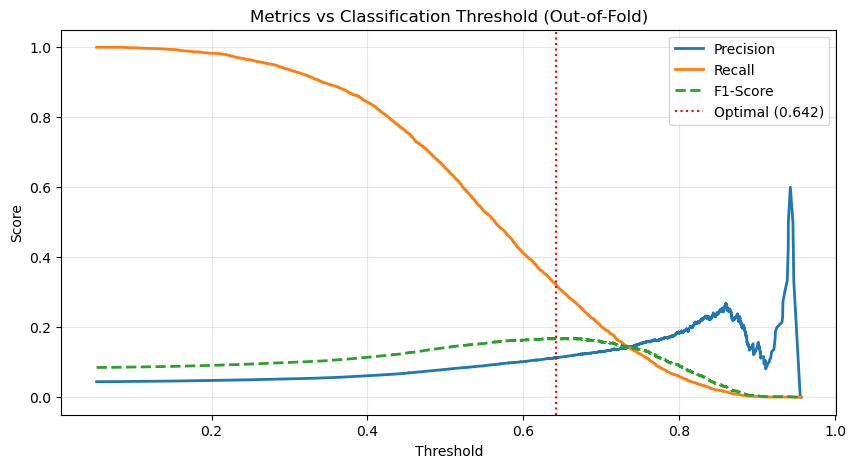

In [17]:
# ============================================================================
# CELL: Find Optimal Threshold (CORRECTED VERSION)
# ============================================================================

from sklearn.model_selection import cross_val_predict

# Get out-of-fold predictions on training data
# This ensures we're not using the same data the model was trained on
y_proba_oof = cross_val_predict(
    best_model, 
    X_train_final, 
    y_train_combined, 
    cv=5, 
    method='predict_proba'
)[:, 1]

# Calculate precision-recall curve on out-of-fold predictions
precisions, recalls, thresholds = precision_recall_curve(y_train_combined, y_proba_oof)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)

# Find optimal threshold (maximize F1)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision: {precisions[optimal_idx]:.4f}")
print(f"Recall: {recalls[optimal_idx]:.4f}")
print(f"F1-Score: {f1_scores[optimal_idx]:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, linestyle='--')
plt.axvline(optimal_threshold, color='red', linestyle=':', label=f'Optimal ({optimal_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Classification Threshold (Out-of-Fold)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
evaluate_model(best_model, X_test, 0.6422, file_out='log_reg_3.csv')

Base predicted churn: 61.78%
Predicted churn at 0.6422 threshold: 28.41%
Submission saved to log_reg_3.csv
